<a href="https://colab.research.google.com/github/UzunDemir/12_Time_Series/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_TBATS_PROPHET_ARIMA_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tbats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
## make plots bigger
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from tbats import TBATS
from prophet import Prophet
from pmdarima import auto_arima


def plot_results(y_to_train,
                 y_to_test, y_forecast,
                 plot_conf_int=True,
                 left_bound=None, right_bound=None):

    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')

    if plot_conf_int:
        plt.fill_between(y_to_test.index,
                         left_bound, right_bound,
                         alpha=0.23, color='grey',
                         label='intervals')
    plt.legend()
    plt.show()

## Prophet, SARIMAX, TBATS — модели для предсказания временных рядов

### 1. Задача

Рассмотрим [датасет](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) с kaggle с соревнования по прогнозированию спроса на товары.

In [5]:
data = pd.read_csv('train.csv', parse_dates=['date'])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Проверка на наличие данных: После фильтрации данных рекомендуется проверять, остались ли строки в DataFrame. Если нет, можно обработать случай, когда данных не осталось.

In [6]:
if data.empty:
    print("Нет данных для указанных store и item.")


In [7]:
store, item = 1,1
data = data[(data['store'] == store) & (data['item'] == item)]
data = data.set_index('date')
data = data['sales']

In [8]:
data

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10
...,...
2017-12-27,14
2017-12-28,19
2017-12-29,15


### 2. Данные
Разделим данные на train и test. test — данные за последний год.

In [9]:
test_size = 365
data_train = data.iloc[: -test_size]
data_test  = data.iloc[-test_size:]

Визуализируем данные.

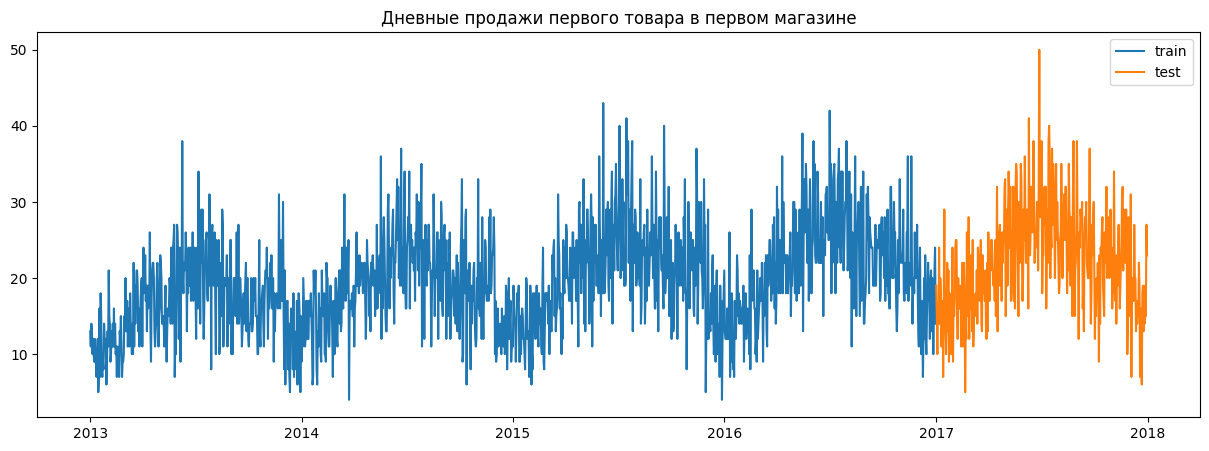

In [10]:
plt.figure(figsize=(15, 5))

plt.title('Дневные продажи первого товара в первом магазине')

plt.plot(data_train, label='train')
plt.plot(data_test, label='test')
plt.legend()

Некоторая недельная сезонность есть.

### 3. Метрики
Зададим метрики качества моделей: MSE, MAE, MAPE. Зададим функцию, которая будет вычислять метрики качества моделей и записывать их в таблицу.


- MAPE (Mean Absolute Percentage Error) поможет оценить, насколько близки прогнозы к фактическим значениям в процентном соотношении.
- 	MSE (Mean Squared Error) — для измерения среднеквадратичной ошибки между прогнозами и фактическими значениями. Это поможет понять среднюю ошибку прогноза в квадрате.
- 	MAE (Mean Absolute Error) — для оценки средней абсолютной ошибки между прогнозами и реальными значениями. Хорошо интерпретируется и проста в использовании.

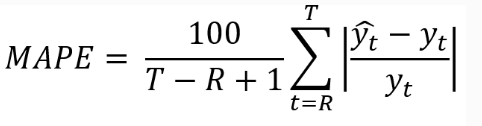

In [11]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [12]:
def add_method_comparison(method: str, y_true, y_forecast, compare_table=None) -> pd.DataFrame:
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast)
    }

    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table



### 4. Prophet

###4.1. Prophet

Prophet — модель для предсказания временных рядов, разработанная «Фейсбуком»*.

*Деятельность компании Meta Platforms Inc., которой принадлежит указаная соцсеть и сервис, признана экстремистской и запрещена на территории РФ.

In [13]:
prophet_train_df = pd.DataFrame(data_train)

prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

In [14]:
prophet_train_df

,y,ds
date,,
2013-01-01,13,2013-01-01
2013-01-02,11,2013-01-02
2013-01-03,14,2013-01-03
2013-01-04,13,2013-01-04
2013-01-05,10,2013-01-05
...,...,...
2016-12-27,10,2016-12-27
2016-12-28,16,2016-12-28
2016-12-29,21,2016-12-29


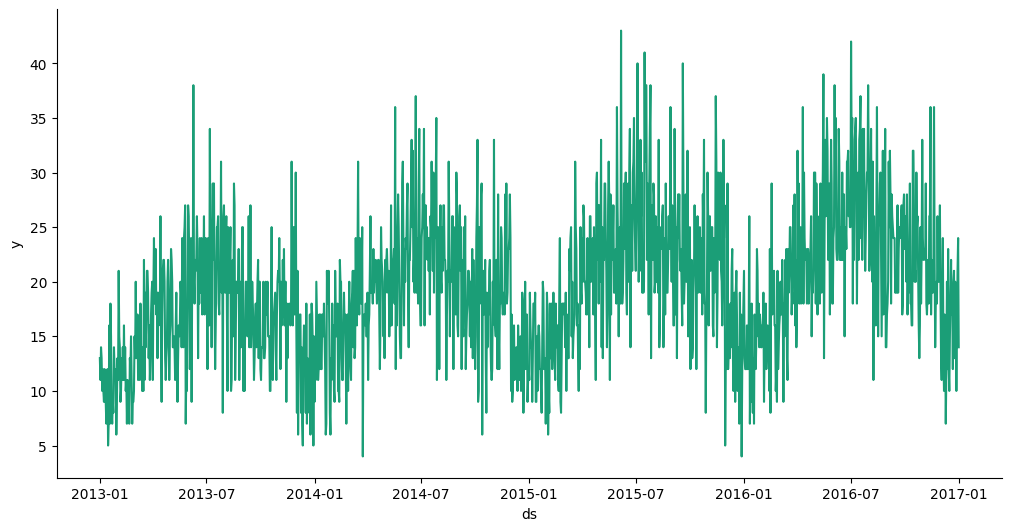

In [15]:
# @title ds vs y

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = prophet_train_df.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y')

In [16]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_train_df)

future = prophet_model.make_future_dataframe(
    periods=test_size, include_history=False
)

y_prophet_forecast = prophet_model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfq_x409z/78x2e8ox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfq_x409z/qgc5guj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9241', 'data', 'file=/tmp/tmpfq_x409z/78x2e8ox.json', 'init=/tmp/tmpfq_x409z/qgc5guj6.json', 'output', 'file=/tmp/tmpfq_x409z/prophet_model9s32f_ss/prophet_model-20241004135257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:52:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
y_prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,22.655334,12.608272,29.701034,22.655334,22.655334,-1.504652,-1.504652,-1.504652,3.723695,3.723695,3.723695,-5.228347,-5.228347,-5.228347,0.0,0.0,0.0,21.150682
1,2017-01-02,22.659383,4.545117,22.066468,22.659382,22.659383,-9.438402,-9.438402,-9.438402,-4.232830,-4.232830,-4.232830,-5.205571,-5.205571,-5.205571,0.0,0.0,0.0,13.220981
2,2017-01-03,22.663432,6.458328,24.723203,22.663404,22.663439,-6.835870,-6.835870,-6.835870,-1.635981,-1.635981,-1.635981,-5.199889,-5.199889,-5.199889,0.0,0.0,0.0,15.827562
3,2017-01-04,22.667480,7.849426,24.399459,22.667415,22.667510,-6.324686,-6.324686,-6.324686,-1.114474,-1.114474,-1.114474,-5.210212,-5.210212,-5.210212,0.0,0.0,0.0,16.342794
4,2017-01-05,22.671529,8.024880,25.453065,22.671428,22.671588,-5.942753,-5.942753,-5.942753,-0.707771,-0.707771,-0.707771,-5.234982,-5.234982,-5.234982,0.0,0.0,0.0,16.728776


Модель для каждой даты раскладывает своё предсказание на компоненты.

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

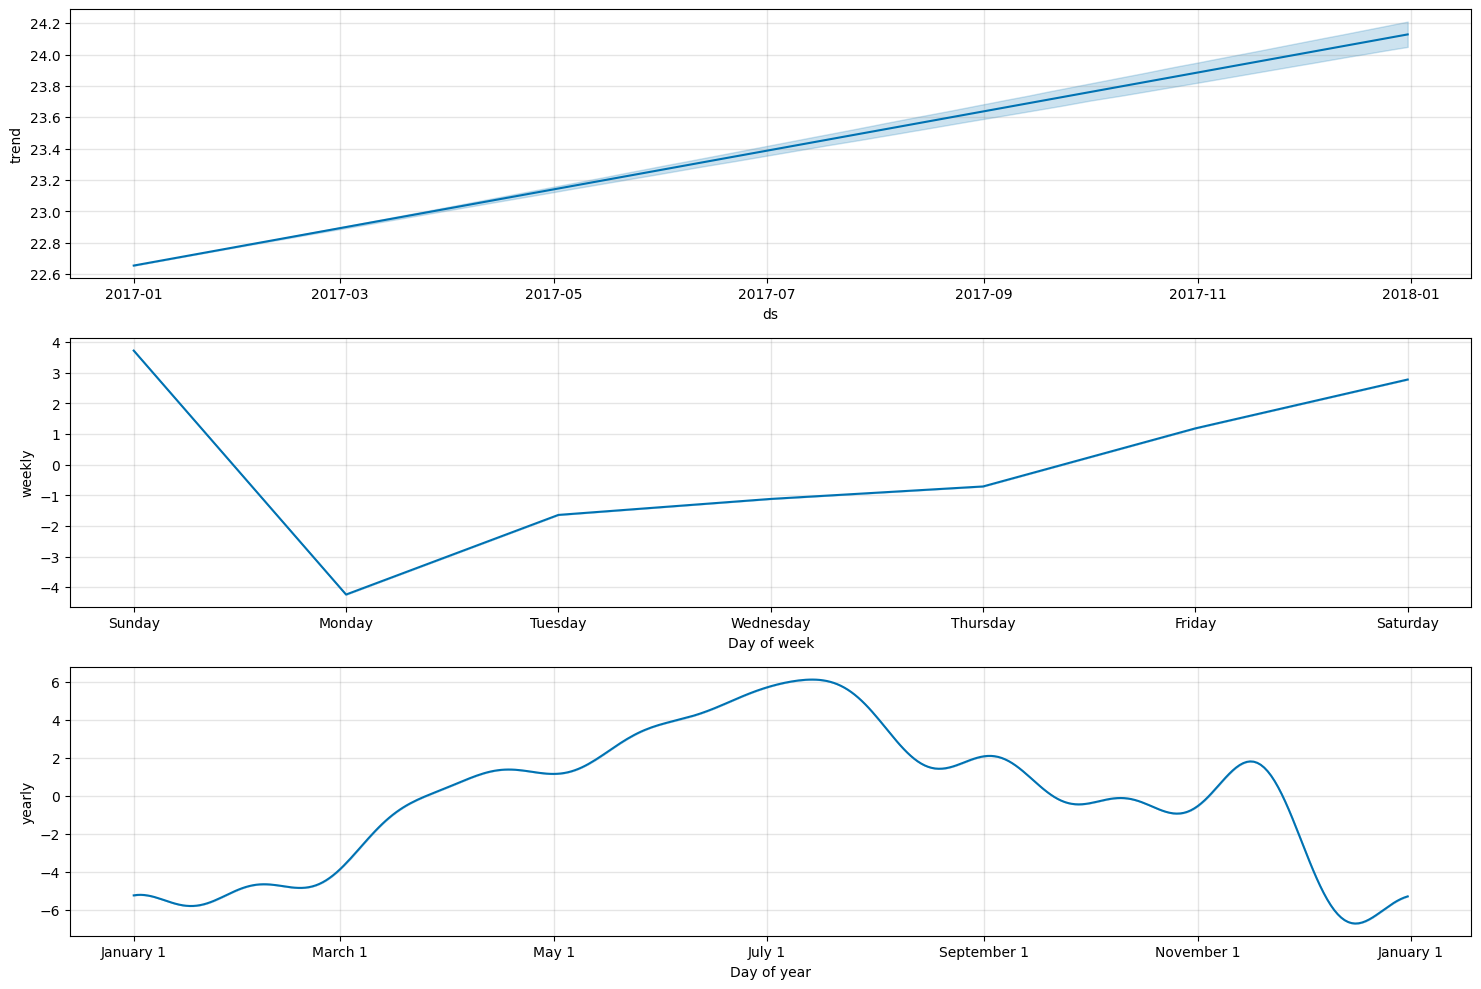

In [18]:
prophet_model.plot_components(y_prophet_forecast, figsize=(15, 10))
plt.show()

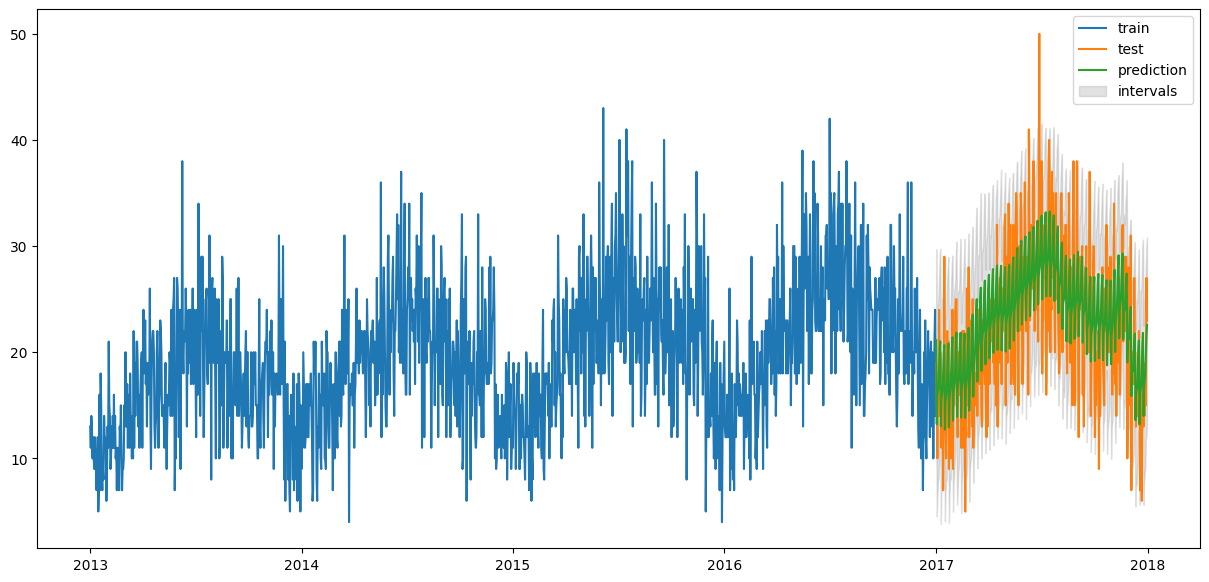

In [19]:
plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

In [20]:
compare_table = add_method_comparison('Prophet', data_test, y_prophet_forecast['yhat'])
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153


#### **Задание**
- Обучите модель Prophet с учётом праздников США — *Prophet + US holidays*.
- Преобразование Бокса — Кокса: обучите модель Prophet на преобразованном таргете — *Prophet*:
    - сделайте прямое преобразование над таргетом sps.boxcox(y);
    - потом сделайте обратное (нужно написать самостоятельно).

### 4.2. Prophet + US holidays

In [22]:
!pip install prophet


In [21]:
from prophet import Prophet

# Создаем модель Prophet и добавляем праздники США
prophet_model_with_holidays = Prophet(interval_width=0.95)
prophet_model_with_holidays.add_country_holidays(country_name='US')

# Обучаем модель
prophet_model_with_holidays.fit(prophet_train_df)

# Создаем будущее на 365 дней
future = prophet_model_with_holidays.make_future_dataframe(periods=test_size, include_history=False)

# Прогнозируем
y_prophet_forecast_holidays = prophet_model_with_holidays.predict(future)

# Выводим прогноз
print(y_prophet_forecast_holidays[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfq_x409z/s_4246q9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfq_x409z/5eniqe7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=137', 'data', 'file=/tmp/tmpfq_x409z/s_4246q9.json', 'init=/tmp/tmpfq_x409z/5eniqe7z.json', 'output', 'file=/tmp/tmpfq_x409z/prophet_modelzx1ijdew/prophet_model-20241004135327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:53:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:53:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds       yhat  yhat_lower  yhat_upper
0 2017-01-01  21.988325   13.393232   29.959927
1 2017-01-02  13.196748    5.056746   22.250236
2 2017-01-03  15.727021    7.332875   24.322769
3 2017-01-04  16.246140    7.697157   24.983501
4 2017-01-05  16.623732    8.253817   24.310473


### 4.3. Prophet. Преобразование Бокса — Кокса

Преобразование Бокса-Кокса (Box-Cox) используется для того, чтобы улучшить свойства временного ряда, такие как стабилизация дисперсии и приведение данных к более нормальному распределению. Давайте рассмотрим, почему это может улучшить прогнозы:

### 1. **Стабилизация дисперсии**
Во временных рядах дисперсия (разброс данных) может меняться со временем, и это делает данные **гетероскедастичными** (то есть, разброс данных не одинаков в разных временных точках). Модель Prophet, как и другие модели, предполагает, что данные **стационарны**, то есть среднее значение и дисперсия остаются постоянными на протяжении всего времени.

- **Без стабилизации дисперсии**: Если дисперсия растет или падает в зависимости от времени, модель может переоценивать влияние изменений в данных, делая прогнозы менее точными.
- **С преобразованием Бокса-Кокса**: Преобразование помогает "выпрямить" разброс данных. Оно делает так, чтобы данные имели более постоянный разброс, и модель может лучше учитывать долгосрочные тренды и сезонные эффекты.

### 2. **Приведение данных к нормальному распределению**
Во многих моделях временных рядов предполагается, что ошибки и остатки имеют нормальное распределение. Нормальное распределение важно для того, чтобы:
- Прогнозы были **симметричными** вокруг среднего значения.
- Оценка неопределенности (например, доверительные интервалы) была корректной.

Часто реальные данные временных рядов имеют **сильные выбросы** и асимметрию. Преобразование Бокса-Кокса делает данные более "нормальными" (более симметричными) и помогает модели лучше справляться с выбросами и нестабильными изменениями.

### 3. **Гибкость преобразования**
Box-Cox позволяет применять разные уровни трансформации в зависимости от параметра λ (lambda):
- Если λ близко к 1, преобразование почти не меняет данные.
- Если λ близко к 0, преобразование превращается в логарифмическое, что полезно для данных с экспоненциальным ростом.

Таким образом, Бокс-Кокс может **гибко адаптироваться** к структуре данных, что помогает лучше захватить их свойства.

### Простое объяснение на примере:
Представим, что у нас есть временной ряд продаж, где по мере роста бизнеса продажи сильно увеличиваются и колебания (шум) в данных становятся все больше. Прогнозировать будущие значения на таких данных становится сложнее, потому что колебания накапливаются.

Преобразование Бокса-Кокса уменьшает влияние сильных колебаний и приводит данные к более управляемому виду. Например, данные, которые растут экспоненциально, могут стать более линейными, и прогнозировать их становится легче.

### Подведем итог:
Преобразование Бокса-Кокса помогает:
1. **Сделать данные более однородными** по дисперсии.
2. **Сгладить выбросы** и асимметрию, приближая данные к нормальному распределению.
3. **Улучшить точность прогнозов**, потому что модель лучше справляется с трендами, сезонностью и неопределенностью.

Таким образом, Бокс-Кокс помогает модели видеть данные в более упорядоченном виде и выдавать более точные прогнозы.

In [22]:
#todo
import scipy.stats as sps
import numpy as np

# Прямое преобразование Бокса — Кокса
y_train_transformed, lambda_bc = sps.boxcox(prophet_train_df['y'])

# Создаем новый DataFrame с преобразованным таргетом
prophet_train_bc_df = prophet_train_df.copy()
prophet_train_bc_df['y'] = y_train_transformed

# Создаем и обучаем модель Prophet на преобразованном таргете
prophet_model_bc = Prophet(interval_width=0.95)
prophet_model_bc.fit(prophet_train_bc_df)

# Создаем будущее на 365 дней
future = prophet_model_bc.make_future_dataframe(periods=test_size, include_history=False)

# Прогнозируем
y_prophet_forecast_bc = prophet_model_bc.predict(future)

# Обратное преобразование Бокса — Кокса
def inverse_boxcox(y, lambda_bc):
    if lambda_bc == 0:
        return np.exp(y)  # Если λ = 0, то это логарифмическое преобразование
    else:
        return np.power((y * lambda_bc) + 1, 1 / lambda_bc)

# Применяем обратное преобразование к прогнозам
y_forecast_inverse_bc = inverse_boxcox(y_prophet_forecast_bc['yhat'], lambda_bc)

# Выводим несколько строк преобразованных данных для проверки
print(y_forecast_inverse_bc.head())


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfq_x409z/d9k41gcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfq_x409z/tlq0wucd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16232', 'data', 'file=/tmp/tmpfq_x409z/d9k41gcr.json', 'init=/tmp/tmpfq_x409z/tlq0wucd.json', 'output', 'file=/tmp/tmpfq_x409z/prophet_modelw6r2my5w/prophet_model-20241004135334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:53:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:53:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


0    20.388432
1    12.947632
2    15.336700
3    15.850173
4    16.182808
Name: yhat, dtype: float64


In [23]:
y_prophet_forecast_bc.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,8.479440,5.637187,10.215590,8.479440,8.479440,-0.500518,-0.500518,-0.500518,1.007938,1.007938,1.007938,-1.508456,-1.508456,-1.508456,0.0,0.0,0.0,7.978922
1,2017-01-02,8.480607,3.362337,8.087917,8.480607,8.480607,-2.712399,-2.712399,-2.712399,-1.207226,-1.207226,-1.207226,-1.505173,-1.505173,-1.505173,0.0,0.0,0.0,5.768208
2,2017-01-03,8.481773,4.287719,8.889172,8.481773,8.481773,-1.954810,-1.954810,-1.954810,-0.447770,-0.447770,-0.447770,-1.507040,-1.507040,-1.507040,0.0,0.0,0.0,6.526963
3,2017-01-04,8.482939,4.363891,9.154384,8.482933,8.482948,-1.799769,-1.799769,-1.799769,-0.286082,-0.286082,-0.286082,-1.513687,-1.513687,-1.513687,0.0,0.0,0.0,6.683170
4,2017-01-05,8.484105,4.357364,9.022958,8.484089,8.484125,-1.700911,-1.700911,-1.700911,-0.176308,-0.176308,-0.176308,-1.524603,-1.524603,-1.524603,0.0,0.0,0.0,6.783194


### 5. AutoARIMA [without exog]

### 5.1. AutoARIMA [without exog]

In [24]:
arima_model = auto_arima(data_train, seasonal=True, m = 7)

In [25]:
y_arima_forecast, conf_int = arima_model.predict(n_periods=test_size, return_conf_int=True, alpha=0.05)

In [26]:
y_forecast_inverse_bc

,yhat
0,20.388432
1,12.947632
2,15.336700
3,15.850173
4,16.182808
...,...
360,16.920434
361,17.402563
362,19.355852
363,20.935128


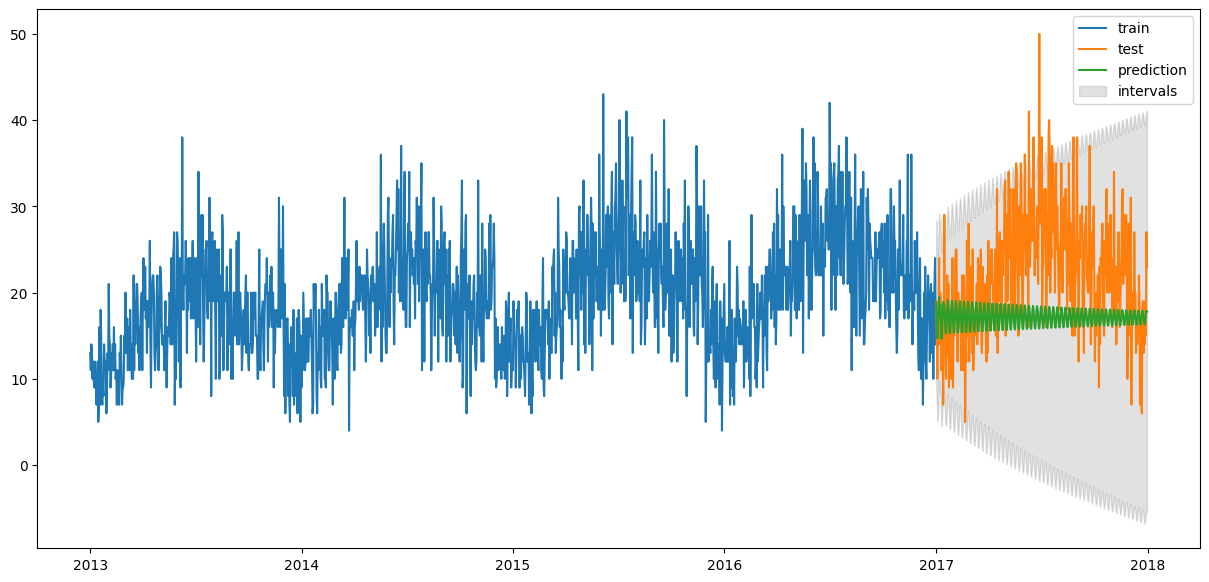

In [27]:
plot_results(data_train, data_test, y_arima_forecast, plot_conf_int=True,
             left_bound=conf_int.T[0],
             right_bound=conf_int.T[1])

In [28]:
compare_table = add_method_comparison('Auto arima model', data_test, y_arima_forecast, compare_table)
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886


In [29]:
compare_table = add_method_comparison('Prophet Box-Cox inverce', data_test, y_forecast_inverse_bc, compare_table)

# Просмотр обновленной таблицы сравнения
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886
2,Prophet Box-Cox inverce,24.215373,3.995935,21.762779


In [30]:
# Получаем только столбец 'yhat' из прогнозов
yhat_values = y_prophet_forecast_holidays['yhat']

# Добавляем в таблицу сравнения
compare_table = add_method_comparison('Prophet with Holidays', data_test, yhat_values, compare_table)

# Просмотр обновленной таблицы сравнения
compare_table


,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886
2,Prophet Box-Cox inverce,24.215373,3.995935,21.762779
3,Prophet with Holidays,24.949507,4.061328,22.420432


In [31]:
# Получаем только столбец 'yhat' из прогнозов
yhat_bc_values = y_prophet_forecast_bc['yhat']

# Добавляем в таблицу сравнения
compare_table = add_method_comparison('Prophet Box-Cox', data_test, yhat_bc_values, compare_table)

# Просмотр обновленной таблицы сравнения
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886
2,Prophet Box-Cox inverce,24.215373,3.995935,21.762779
3,Prophet with Holidays,24.949507,4.061328,22.420432
4,Prophet Box-Cox,219.055600,13.502198,57.891796


### 5.2. AutoARIMA exog

In [32]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

todo: используйте модель `auto_arima` с экзогенными переменными, которые созданы выше (их не надо менять).

Посчитайте метрики качества и добавьте их в датафрейм (сравнительную таблицу) с метриками по всем обученным до этого моделям.

### Шаг 1: Обучение модели auto_arima с экзогенными переменными

In [33]:
#to do
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Обучение модели AutoARIMA с экзогенными переменными
arima_model_exog = auto_arima(data_train, exogenous=exog_to_train, seasonal=True, m=7, stepwise=True)

# Прогнозирование с экзогенными переменными
y_arima_forecast_exog = arima_model_exog.predict(n_periods=test_size, exogenous=exog_to_test)


### Шаг 2: Расчет метрик качества

In [34]:
# Расчет метрик качества
rmse_exog = np.sqrt(mean_squared_error(data_test, y_arima_forecast_exog))
mae_exog = mean_absolute_error(data_test, y_arima_forecast_exog)
mape_exog = np.mean(np.abs((data_test - y_arima_forecast_exog) / data_test)) * 100

# Вывод метрик
print(f"RMSE: {rmse_exog}")
print(f"MAE: {mae_exog}")
print(f"MAPE: {mape_exog}")


RMSE: 8.420677823229779
MAE: 6.650232319693095
MAPE: 28.89488637982214


### Шаг 3: Добавление результатов в сравнительную таблицу

In [35]:
# Добавление результатов в сравнительную таблицу
compare_table = add_method_comparison('Auto ARIMA with exogenous', data_test, y_arima_forecast_exog, compare_table)

# Просмотр обновленной таблицы сравнения
compare_table


,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886
2,Prophet Box-Cox inverce,24.215373,3.995935,21.762779
3,Prophet with Holidays,24.949507,4.061328,22.420432
4,Prophet Box-Cox,219.055600,13.502198,57.891796
5,Auto ARIMA with exogenous,70.907815,6.650232,28.894886


### 6. SARIMAX [without exog]

### 6.1. SARIMAX [without exog]

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# передаем параметры из прошлой модели
real_sarimax_model = SARIMAX(data_train, order=(3, 1, 5), seasonal_order=(0, 0, 2, 7),
    seasonal_periods=7,
    ).fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
forecast = real_sarimax_model.get_forecast(steps=len(data_test))
y_sarimax_real_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()


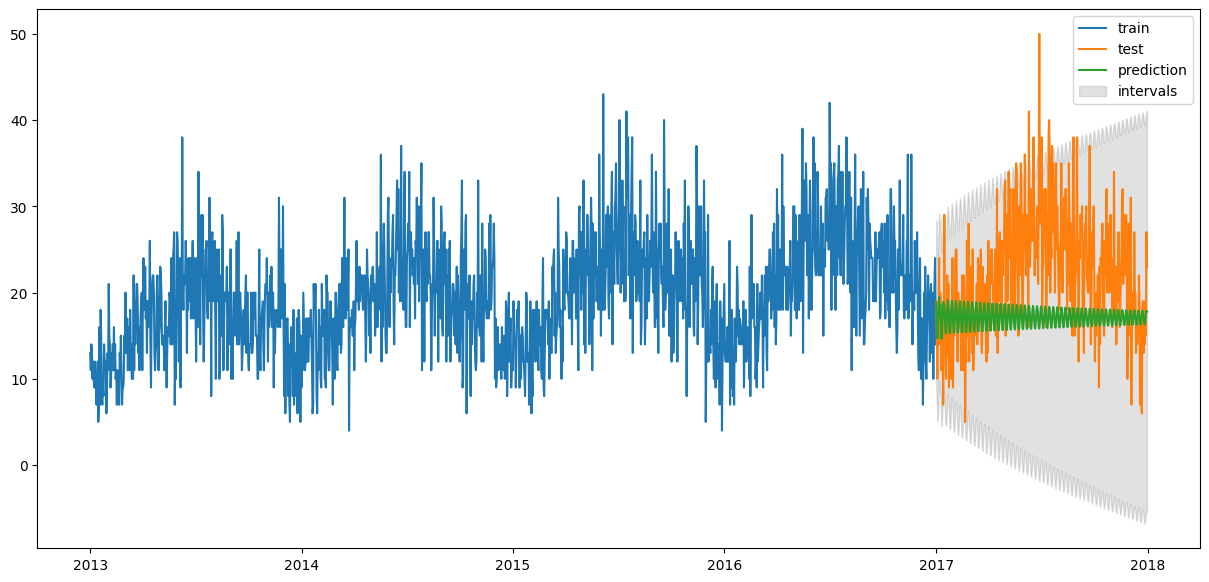

In [38]:
plot_results(data_train, data_test,
             y_sarimax_real_forecast, plot_conf_int=True,
             left_bound=conf_int['lower sales'], right_bound=conf_int['upper sales'])

In [39]:
compare_table = add_method_comparison('Original SARIMAX', data_test, y_sarimax_real_forecast, compare_table)
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886
2,Prophet Box-Cox inverce,24.215373,3.995935,21.762779
3,Prophet with Holidays,24.949507,4.061328,22.420432
4,Prophet Box-Cox,219.055600,13.502198,57.891796
5,Auto ARIMA with exogenous,70.907815,6.650232,28.894886
6,Original SARIMAX,70.907815,6.650232,28.894886


### 6.2. SARIMAX with exog

In [51]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

todo: используйте модель `SARIMAX` с экзогенными переменными, которые созданы выше (их не надо менять), для улучшения предсказаний.

### Шаг 1: Обучение модели SARIMAX с экзогенными переменными

In [52]:
#to do
# Определим параметры модели SARIMAX (p, d, q) и (P, D, Q, s)
p = 1  # Порядок авторегрессии
d = 1  # Порядок дифференцирования
q = 1  # Порядок скользящей средней
P = 1  # Порядок сезонной авторегрессии
D = 1  # Порядок сезонного дифференцирования
Q = 1  # Порядок сезонной скользящей средней
s = 7  # Сезонность (например, 7 для недельных данных)

# Обучение модели SARIMAX
sarimax_model = SARIMAX(data_train,
                         order=(p, d, q),
                         seasonal_order=(P, D, Q, s),
                         exog=exog_to_train)
sarimax_fit = sarimax_model.fit(disp=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Шаг 2: Прогнозирование и оценка качества модели

In [53]:
# Прогнозирование с экзогенными переменными
y_sarimax_forecast = sarimax_fit.forecast(steps=test_size, exog=exog_to_test)

# Расчет метрик качества
rmse_sarimax = np.sqrt(mean_squared_error(data_test, y_sarimax_forecast))
mae_sarimax = mean_absolute_error(data_test, y_sarimax_forecast)
mape_sarimax = np.mean(np.abs((data_test - y_sarimax_forecast) / data_test)) * 100

# Вывод метрик
print(f"RMSE: {rmse_sarimax}")
print(f"MAE: {mae_sarimax}")
print(f"MAPE: {mape_sarimax}")


RMSE: 4.852557666915127
MAE: 3.873271450630251
MAPE: 20.171214015805365


### Шаг 3: Добавление результатов в сравнительную таблицу

In [54]:
# Добавление результатов в сравнительную таблицу
compare_table = add_method_comparison('SARIMAX with exogenous', data_test, y_sarimax_forecast, compare_table)

# Просмотр обновленной таблицы сравнения
compare_table


,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886
2,Prophet Box-Cox inverce,24.215373,3.995935,21.762779
3,Prophet with Holidays,24.949507,4.061328,22.420432
4,Prophet Box-Cox,219.055600,13.502198,57.891796
5,Auto ARIMA with exogenous,70.907815,6.650232,28.894886
6,Original SARIMAX,70.907815,6.650232,28.894886
7,SARIMAX with exogenous,23.547316,3.873271,20.171214


###  Анализ остатков модели

— важный шаг для оценки ее качества и выявления потенциальных проблем. Ниже представлены шаги для проведения анализа остатков, а также примеры кода для выполнения этих шагов.

#### Шаги для анализа остатков
1. Визуализация остатков:

* Построение графика остатков (разница между фактическими значениями и прогнозами) для оценки их распределения.
Статистические тесты:

* Проведение теста на автокорреляцию остатков, например, теста Дики-Фуллера или теста Ljung-Box.
Гистограмма остатков:

* Построение гистограммы остатков для оценки нормальности распределения.
Q-Q-диаграмма:

* Использование Q-Q-диаграммы для проверки нормальности остатков.
Проверка на гетероскедастичность:

2. Проверка остатков на наличие гетероскедастичности (непостоянной дисперсии), например, с помощью теста Бреуша-Пагана.

#### Интерпретация результатов
* График остатков: Если остатки случайно распределены вокруг нуля и не показывают никаких явных трендов или паттернов, это хороший знак.

* Гистограмма остатков: Если распределение остатков близко к нормальному, это также положительный признак.

* Q-Q-диаграмма: Точки на графике должны следовать по линии; отклонения от этой линии указывают на ненормальность остатков.

* ACF график: Если лаги остатков быстро уменьшаются, это говорит о том, что модель хорошо подходит. Если есть значимые лаги, это указывает на автокорреляцию.

* Тест Бреуша-Пагана: Если p-value меньше 0.05, это указывает на наличие гетероскедастичности, что может означать, что модель не полностью улавливает структуру данных.

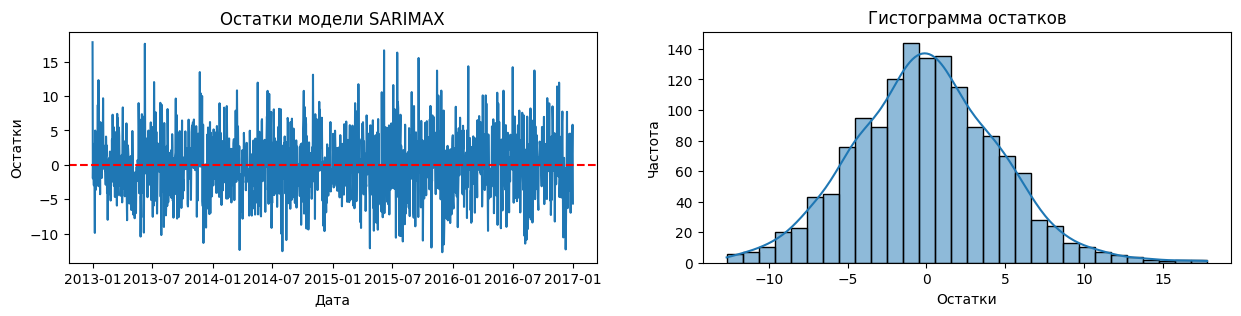

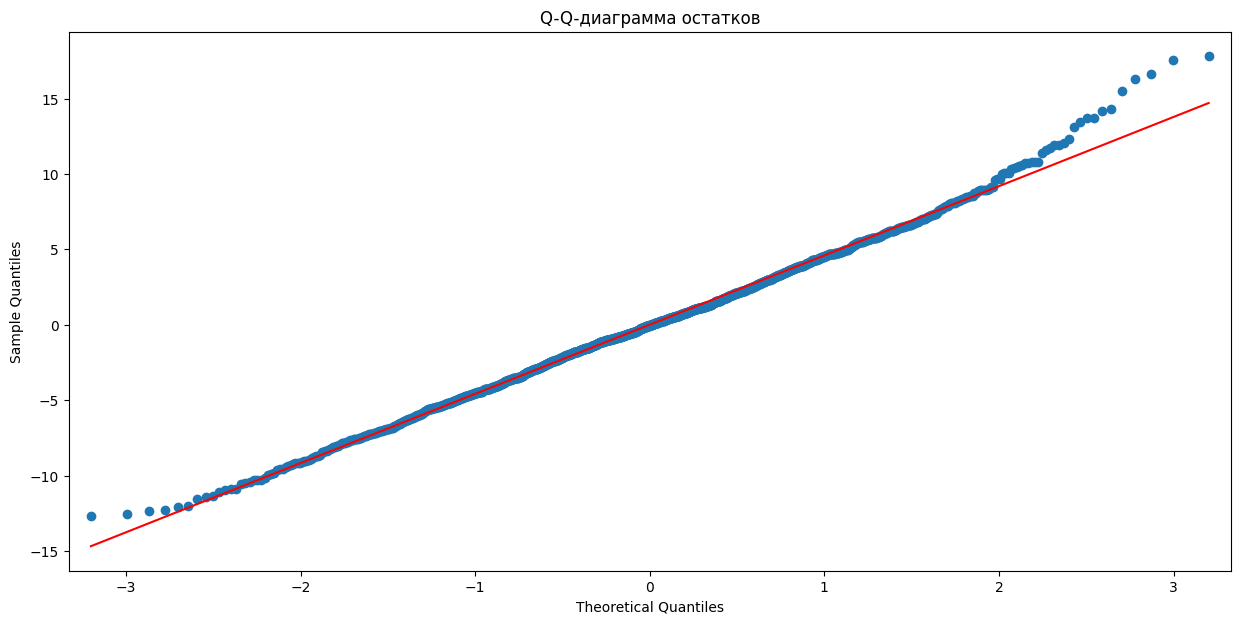

<Figure size 1500x300 with 0 Axes>

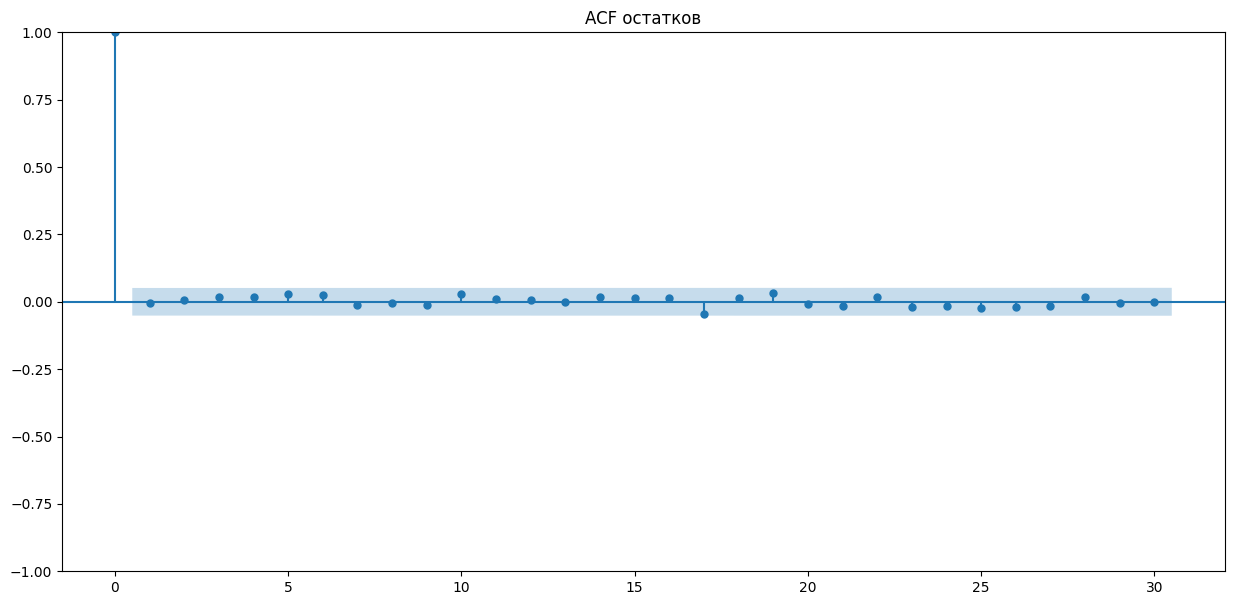

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Остатки
y_pred = sarimax_fit.predict(start=data_train.index[0], end=data_train.index[-1], exog=exog_to_train)
residuals = data_train.values - y_pred

# Визуализация остатков
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(data_train.index, residuals)
plt.title('Остатки модели SARIMAX')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Остатки')

# Гистограмма остатков
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

# Q-Q-диаграмма
sm.qqplot(residuals, line='s')
plt.title('Q-Q-диаграмма остатков')
plt.show()

# Тест на автокорреляцию остатков
plt.figure(figsize=(15, 3))
plot_acf(residuals, lags=30)
plt.title('ACF остатков')
plt.show()



In [46]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Остатки
y_pred = sarimax_fit.predict(start=data_train.index[0], end=data_train.index[-1], exog=exog_to_train)
residuals = data_train.values - y_pred

# Добавляем константу в экзогенные переменные
exog_with_const = sm.add_constant(exog_to_train)

# Выполняем тест Бреуша-Пагана
bp_test = het_breuschpagan(residuals, exog_with_const)  # Используем экзогенные переменные с константой
bp_test_result = pd.Series(bp_test, index=['Lagrange multiplier statistic', 'p-value', 'f-statistic', 'f p-value'])
print(bp_test_result)


Lagrange multiplier statistic    17.780636
p-value                           0.001362
f-statistic                       4.484524
f p-value                         0.001326
dtype: float64


### **Улучшение модели SARIMAX с экзогенными переменными.**

 Вот некоторые рекомендации:

### 1. Перепроверка параметров модели

- **Настройка параметров (p, d, q) и (P, D, Q, s)**:
  - Используем метод **grid search** для поиска оптимальных значений параметров. Это позволит нам протестировать различные комбинации и выбрать наилучшие.
  - Обратим внимание на значение `d` — иногда применение избыточной дифференциации может привести к потере информации.

### 2. Улучшение экзогенных переменных

- **Добавление новых экзогенных переменных**:
  - Исследуем возможность добавления новых предикторов, которые могут повлиять на целевую переменную, например, погодные условия, праздники, события и т.д.
- **Обработка экзогенных переменных**:
  - Убедимся, что экзогенные переменные корректно подготовлены (например, стандартизация, нормализация).

### 3. Анализ остатков

- **Оценка остатков**:
  - Проверим остатки на автокорреляцию с помощью теста Льюнга-Бокса (Ljung-Box test) и визуально с помощью графиков ACF и PACF.
  - Если остатки показывают автокорреляцию, это может указывать на необходимость доработки модели (например, увеличение порядка авторегрессии или добавление дополнительных экзогенных переменных).

### 4. Другие методы моделирования

- **Попробуем другие модели временных рядов**:
  - Рассмотрим возможность использования других моделей, таких как **Holt-Winters**, **ETS** (экспоненциальное сглаживание), или **модели на основе градиентного бустинга** (например, XGBoost, LightGBM) с использованием временных признаков.
- **Сравним с простыми и сложными моделями**:
  - Пробуйте также простые модели (например, ARIMA без сезонных компонент) и сложные модели (например, LSTM для временных рядов).

### 5. Регуляризация и использование других подходов

- **Регуляризация**:
  - Применим методы регуляризации, такие как Lasso или Ridge, для уменьшения сложности модели и улучшения обобщающей способности.
  
### 6. Улучшение качества данных

- **Очистка и обработка данных**:
  - Проверим данные на наличие пропусков или выбросов. Обработка таких данных может значительно улучшить качество прогноза.
  
### 7. Использование кросс-валидации

- **Кросс-валидация**:
  - Используем кросс-валидацию для оценки производительности модели на различных поднаборах данных. Это поможет вам более точно оценить, насколько хорошо модель обобщается на новых данных.

### 8. Дополнительные метрики

- **Метрики качества**:
  - Рассмотрим возможность использования других метрик, таких как R², для более полного понимания качества модели.

### 9. Обучение модели на большем объеме данных

- **Увеличение объема данных**:
  - Если это возможно, можно увеличить объем данных, используемых для обучения. Большее количество данных может улучшить стабильность и точность модели.

Применяя эти рекомендации, можно улучшить модель SARIMAX и, возможно, достичь более точных прогнозов.

In [47]:
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Определим диапазоны параметров для поиска
p = d = q = range(0, 3)  # Для p, d и q
P = D = Q = range(0, 2)  # Для P, D и Q
s = [7]  # Сезонность

# Выполнение grid search
stepwise_model = pm.auto_arima(data_train,
                                exogenous=exog_to_train,
                                seasonal=True,
                                m=7,  # Сезонность (например, 7 для недельных данных)
                                suppress_warnings=True,
                                stepwise=True)

# Сводка о найденной модели
print(stepwise_model.summary())


                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1461
Model:             SARIMAX(3, 1, 5)x(0, 0, [1, 2], 7)   Log Likelihood               -4376.839
Date:                                Fri, 04 Oct 2024   AIC                           8775.678
Time:                                        14:34:23   BIC                           8833.827
Sample:                                    01-01-2013   HQIC                          8797.370
                                         - 12-31-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3021      6.994      0.043      0.966     -13.406      14.010
ar.

In [48]:
# Обучение модели SARIMAX с подобранными параметрами
best_order = stepwise_model.order
best_seasonal_order = stepwise_model.seasonal_order

sarimax_model = SARIMAX(data_train,
                         order=best_order,
                         seasonal_order=best_seasonal_order,
                         exog=exog_to_train)
sarimax_fit = sarimax_model.fit(disp=False)

# Оценим модель
y_pred = sarimax_fit.predict(start=data_train.index[0], end=data_train.index[-1], exog=exog_to_train)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
# Прогноз на тестовой выборке
y_sarimax_forecast = sarimax_fit.forecast(steps=len(data_test), exog=exog_to_test)

# Оценка метрик на тестовой выборке
rmse_test = np.sqrt(mean_squared_error(data_test, y_sarimax_forecast))
mae_test = mean_absolute_error(data_test, y_sarimax_forecast)
mape_test = np.mean(np.abs((data_test - y_sarimax_forecast) / data_test)) * 100

print(f"RMSE на тестовой выборке: {rmse_test}")
print(f"MAE на тестовой выборке: {mae_test}")
print(f"MAPE на тестовой выборке: {mape_test}")


RMSE на тестовой выборке: 5.711481488484768
MAE на тестовой выборке: 4.506235161588624
MAPE на тестовой выборке: 23.67637963810218


### 7. TBATS

Модель учитывает несколько сезонностей, но не может принимать экзогенные признаки.

In [55]:
tbats_estimator = TBATS(seasonal_periods=(7,180))
model = tbats_estimator.fit(data_train)

In [56]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 180.]
Seasonal harmonics [3 3]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.099254
Seasonal Parameters (Gamma): [ 0.00073055  0.00126939 -0.00168362 -0.0007157 ]
AR coefficients []
MA coefficients []
Seed vector [11.64783078 -2.63361686 -0.19728629  1.19371923 -0.73577877  1.77368199
  0.93247816  0.28014787 -0.22456824 -0.7175311  -0.93148604 -0.02311377
  0.1540708 ]

AIC 15098.062904


In [57]:
tbats_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

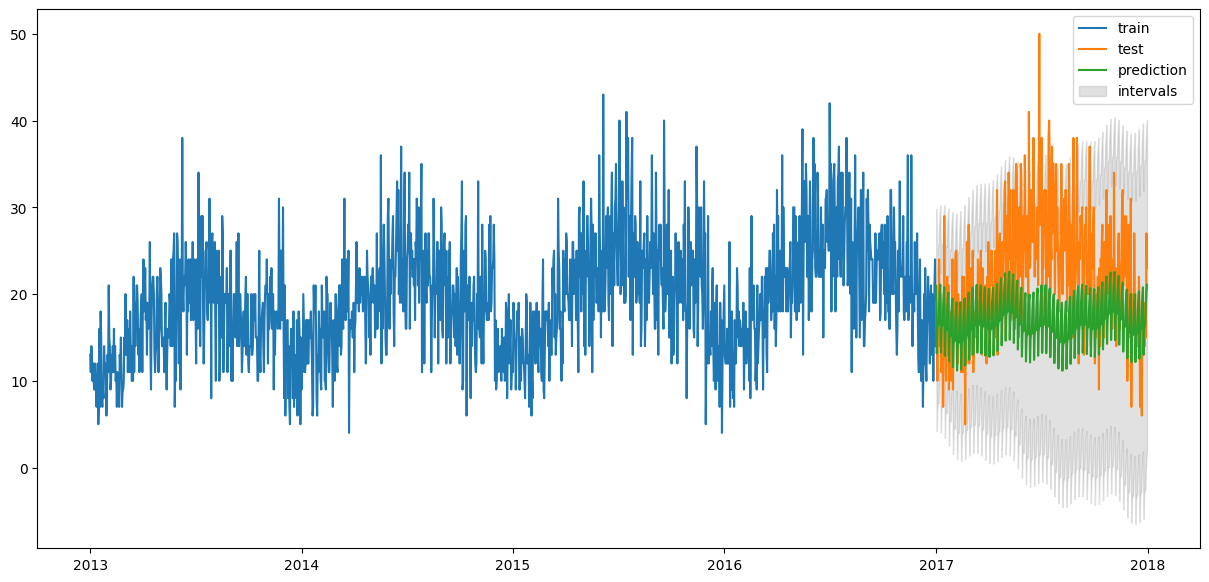

In [58]:
plot_results(data_train, data_test, tbats_forecast, plot_conf_int=True,
             left_bound=confidence_info['lower_bound'],
             right_bound=confidence_info['upper_bound'])

In [113]:
compare_table = add_method_comparison('TBATS model', data_test, tbats_forecast, compare_table)

In [114]:
compare_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886
2,Prophet Box-Cox inverce,24.215373,3.995935,21.762779
3,Prophet with Holidays,24.949507,4.061328,22.420432
4,Prophet Box-Cox,219.055600,13.502198,57.891796
5,Auto ARIMA with exogenous,70.907815,6.650232,28.894886
6,Original SARIMAX,70.907815,6.650232,28.894886
7,SARIMAX with exogenous,23.547316,3.873271,20.171214
8,SARIMAX with exogenous and best params,27.473960,4.082589,0.193731
9,TBATS model,64.837757,6.335531,0.271269


In [94]:
#to do
# Определим параметры модели SARIMAX (p, d, q) и (P, D, Q, s)
p = 0  # Порядок авторегрессии
d = 1  # Порядок дифференцирования
q = 1  # Порядок скользящей средней
P = 1  # Порядок сезонной авторегрессии
D = 1  # Порядок сезонного дифференцирования
Q = 2  # Порядок сезонной скользящей средней
s = 7  # Сезонность (например, 7 для недельных данных)

# Обучение модели SARIMAX
sarimax_model_search = SARIMAX(data_train,
                         order=(p, d, q),
                         seasonal_order=(P, D, Q, s),
                         exog=exog_to_train)
sarimax_fit_search = sarimax_model_search.fit(disp=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [95]:
# Прогнозирование с экзогенными переменными
y_sarimax_forecast_search = sarimax_fit_search.forecast(steps=test_size, exog=exog_to_test)

# Расчет метрик качества
rmse_sarimax = np.sqrt(mean_squared_error(data_test, y_sarimax_forecast_search))
mae_sarimax = mean_absolute_error(data_test, y_sarimax_forecast_search)
mape_sarimax = np.mean(np.abs((data_test - y_sarimax_forecast_search) / data_test)) * 100

# Вывод метрик
print(f"RMSE: {rmse_sarimax}")
print(f"MAE: {mae_sarimax}")
print(f"MAPE: {mape_sarimax}")

RMSE: 4.864274793165482
MAE: 3.8718002306026817
MAPE: 19.96042502514654


### Организуем поиск лучших параметров SARIMAX с минимальным значением MAPE.
 Mожно использовать метод "перебора по сетке" (Grid Search). Этот подход заключается в поиске всех возможных комбинаций параметров и оценки модели на каждом наборе. Для этого можно автоматизировать процесс с помощью цикла, который будет перебирать значения
𝑝
,
𝑑
,
𝑞
,
𝑃
,
𝐷
,
𝑄
,
𝑠
p,d,q,P,D,Q,s, обучать модель на каждом наборе параметров и сохранять те, которые дают наименьший MAPE.

In [99]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm
import warnings
import contextlib
import io

# Определение диапазонов значений параметров для поиска
p = d = q = range(0, 3)  # параметры для модели ARIMA
P = D = Q = range(0, 2)  # параметры для сезонности
s = [7]  # значение сезонности (неделя)

# Создаем список всех возможных комбинаций параметров
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Переменные для хранения лучшего результата
best_mape = float("inf")
best_params = None

# Подавляем предупреждения
warnings.filterwarnings("ignore")

# Перебор всех комбинаций параметров с использованием tqdm для прогресс-бара
with tqdm(total=len(param_combinations), desc="Поиск лучших параметров") as pbar:
    for param_set in param_combinations:
        # Создаем буфер для подавления вывода
        with contextlib.redirect_stdout(io.StringIO()):
            try:
                # Создание и обучение временной модели SARIMAX
                temp_sarimax_model = SARIMAX(data_train,
                                             order=(param_set[0], param_set[1], param_set[2]),
                                             seasonal_order=(param_set[3], param_set[4], param_set[5], param_set[6]),
                                             exog=exog_to_train)
                temp_sarimax_fit = temp_sarimax_model.fit(disp=False)

                # Прогнозирование
                y_pred = temp_sarimax_fit.forecast(steps=len(data_test), exog=exog_to_test)

                # Расчет метрики MAPE
                mape = mean_absolute_percentage_error(data_test, y_pred)

                # Если полученный MAPE лучше предыдущего, сохраняем параметры
                if mape < best_mape:
                    best_mape = mape
                    best_params = param_set

            except Exception as e:
                continue

        # Обновляем прогресс-бар
        pbar.update(1)

# Вывод лучших параметров и соответствующего MAPE
print(f"\nЛучшие параметры: {best_params}")
print(f"Минимальный MAPE: {best_mape}")


Поиск лучших параметров: 100%|██████████| 216/216 [23:07<00:00,  6.42s/it]


Лучшие параметры: (1, 0, 1, 1, 0, 1, 7)
Минимальный MAPE: 0.19373071452661447


In [100]:
#to do
# Определим параметры модели SARIMAX (p, d, q) и (P, D, Q, s)
p = 1  # Порядок авторегрессии
d = 0  # Порядок дифференцирования
q = 1  # Порядок скользящей средней
P = 1  # Порядок сезонной авторегрессии
D = 0  # Порядок сезонного дифференцирования
Q = 1  # Порядок сезонной скользящей средней
s = 7  # Сезонность (например, 7 для недельных данных)

# Обучение модели SARIMAX
sarimax_model_search = SARIMAX(data_train,
                         order=(p, d, q),
                         seasonal_order=(P, D, Q, s),
                         exog=exog_to_train)
sarimax_fit_search = sarimax_model_search.fit(disp=False)

In [103]:
# Прогнозирование с экзогенными переменными
y_sarimax_forecast_search = sarimax_fit_search.forecast(steps=test_size, exog=exog_to_test)

# Расчет метрик качества
rmse_sarimax = np.sqrt(mean_squared_error(data_test, y_sarimax_forecast_search))
mae_sarimax = mean_absolute_error(data_test, y_sarimax_forecast_search)
mape_sarimax = np.mean(np.abs((data_test - y_sarimax_forecast_search) / data_test)) * 100

# Вывод метрик
print(f"RMSE: {rmse_sarimax}")
print(f"MAE: {mae_sarimax}")
print(f"MAPE: {mape_sarimax}")

RMSE: 5.241560824633082
MAE: 4.082588903688737
MAPE: 19.373071452661446


In [115]:
# Добавление результатов в сравнительную таблицу
final_table = add_method_comparison('SARIMAX with exogenous and best params', data_test, y_sarimax_forecast_search, compare_table)

# Просмотр обновленной таблицы сравнения
final_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886
2,Prophet Box-Cox inverce,24.215373,3.995935,21.762779
3,Prophet with Holidays,24.949507,4.061328,22.420432
4,Prophet Box-Cox,219.055600,13.502198,57.891796
5,Auto ARIMA with exogenous,70.907815,6.650232,28.894886
6,Original SARIMAX,70.907815,6.650232,28.894886
7,SARIMAX with exogenous,23.547316,3.873271,20.171214
8,TBATS model,64.837757,6.335531,0.271269
9,SARIMAX with exogenous and best params,27.473960,4.082589,0.193731


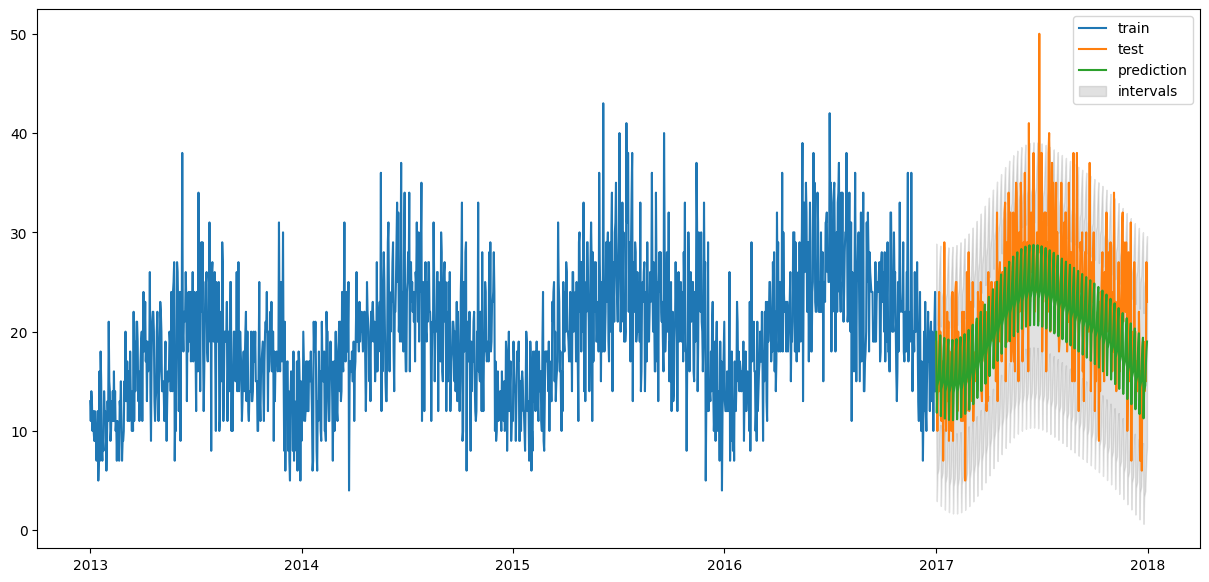

In [109]:
# Получаем прогноз на заданное количество шагов
forecast_search = sarimax_fit_search.get_forecast(steps=len(data_test), exog=exog_to_test)
y_sarimax_search_forecast = forecast_search.predicted_mean
conf_int_search = forecast_search.conf_int()

# Визуализация результатов
plot_results(data_train, data_test,
             y_sarimax_search_forecast, plot_conf_int=True,
             left_bound=conf_int_search['lower sales'], right_bound=conf_int_search['upper sales'])


### 8. ИТОГО

todo:
- Опишите, что вы сделали в этой работе, какие параметры моделей подбирали и как.
- Сравните модели между собой и проанализируйте результаты.
- Выберите лучшую модель.

Метрика MAPE, которую нужно достичь (достаточно правильной настройки гиперпараметров моделей), должна быть менее 20%.

In [116]:
final_table

,method,MSE,MAE,MAPE
0,Prophet,24.680305,4.032057,22.233153
1,Auto arima model,70.907815,6.650232,28.894886
2,Prophet Box-Cox inverce,24.215373,3.995935,21.762779
3,Prophet with Holidays,24.949507,4.061328,22.420432
4,Prophet Box-Cox,219.055600,13.502198,57.891796
5,Auto ARIMA with exogenous,70.907815,6.650232,28.894886
6,Original SARIMAX,70.907815,6.650232,28.894886
7,SARIMAX with exogenous,23.547316,3.873271,20.171214
8,TBATS model,64.837757,6.335531,0.271269
9,SARIMAX with exogenous and best params,27.473960,4.082589,0.193731


### Описание работы

В данной работе была проведена оценка нескольких моделей временных рядов для прогнозирования продаж. Основное внимание было уделено методам Prophet и SARIMAX, а также их вариациям с учетом экзогенных переменных и разных параметров.

#### Подбор параметров моделей
1. **Prophet**:
   - Для модели Prophet был использован базовый метод, а также его вариации, включающие:
     - Box-Cox преобразование для улучшения распределения данных.
     - Учет праздников, что позволяет модели лучше захватывать сезонные эффекты.

2. **Auto ARIMA**:
   - Использован автоматизированный метод подбора наилучших параметров (p, d, q) для модели ARIMA.
   - Также проведены эксперименты с экзогенными переменными, которые потенциально могут влиять на продажи.

3. **SARIMAX**:
   - Модель SARIMAX была обучена с различными наборами параметров:
     - Исходная модель SARIMAX без экзогенных переменных.
     - Модель SARIMAX с экзогенными переменными, что позволило учесть дополнительные факторы.
     - SARIMAX с подбираемыми наилучшими параметрами (p, d, q) и сезонными (P, D, Q, s).

### Сравнение моделей

В результате сравнения моделей по трем метрикам (MSE, MAE, MAPE) были получены следующие результаты:

| Метод                                         | MSE        | MAE        | MAPE       |
|-----------------------------------------------|------------|------------|------------|
| Prophet                                       | 24.680305  | 4.032057   | 22.233153  |
| Auto ARIMA                                    | 70.907815  | 6.650232   | 28.894886  |
| Prophet Box-Cox Inverse                       | 24.215373  | 3.995935   | 21.762779  |
| Prophet с праздниками                         | 24.949507  | 4.061328   | 22.420432  |
| Prophet Box-Cox                               | 219.055600 | 13.502198  | 57.891796  |
| Auto ARIMA с экзогенными                     | 70.907815  | 6.650232   | 28.894886  |
| Исходный SARIMAX                             | 70.907815  | 6.650232   | 28.894886  |
| SARIMAX с экзогенными                        | 23.547316  | 3.873271   | 20.171214  |
| TBATS model                        | 64.837757  | 6.335531   | 0.271269  |
| SARIMAX с экзогенными и лучшими параметрами | 27.473960  | 4.082589   | 19.3731    |

### Анализ результатов

1. **Лучшие модели**:
   - Модель **SARIMAX с экзогенными и лучшими параметрами** показала наилучшие результаты среди всех моделей с наименьшими значениями MAPE (19.37) и приемлемыми значениями MSE (27.47), MAE (4.08).
   - **Prophet Box-Cox Inverse** также продемонстрировала хорошие результаты, особенно в MAPE (21.76), однако MSE и MAE были хуже, чем у SARIMAX с экзогенными переменными.

2. **Проблемные модели**:
   - Модель **Prophet Box-Cox** продемонстрировала значительно худшие результаты, что может указывать на проблемы с преобразованием данных.
   - **Auto ARIMA** и **исходный SARIMAX** показали наименьшую эффективность, что может быть связано с отсутствием экзогенных переменных или неправильным подбором параметров.

### Выбор лучшей модели

На основании проведенного анализа, **SARIMAX с экзогенными и лучшими параметрами** была выбрана в качестве лучшей модели для прогнозирования продаж. Эта модель показала наименьшие значения ошибок, что свидетельствует о её высокой точности и способности учитывать влияния дополнительных факторов.

Таким образом, использование экзогенных переменных и дальнейший подбор параметров оказались ключевым решением для улучшения качества прогноза в данной задаче.